In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import zipfile
import os

In [6]:
# ! mv /content/signet_english.h5 /content/ckpts/

In [7]:
# List of directories you want to create
directories = ['/content/CSVS', '/content/DATASET', '/content/ckpts']

# Loop through each directory and create it if it doesn't exist
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

Directory already exists: /content/CSVS
Directory already exists: /content/DATASET
Directory already exists: /content/ckpts


In [ ]:
# Specify the path to the zip file you want to extract
zip_file_path = "/content/drive/MyDrive/Datasets/CEDAR.zip"

# Specify the target folder where you want to extract the contents
extract_folder = '/content/DATASET'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file into the target folder
    zip_ref.extractall(extract_folder)

print(f'Extracted contents from {zip_file_path} to {extract_folder}')
drive.flush_and_unmount()


## Start work here

* Dataset Folder : /content/DATASET/CEDAR/CEDAR

In [9]:
import os
import pandas as pd
from itertools import combinations
import random

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import cv2
import numpy as np


In [10]:
def create_signature_dataframe(root_folder, random_state=None):
    data = []

    # Set the seed for reproducibility
    random.seed(random_state)

    # List all subfolders (corresponding to different people)
    person_folders = os.listdir(root_folder)

    # Iterate through each person's folder
    for person_folder in person_folders:
        person_path = os.path.join(root_folder, person_folder)

        # List all original signatures
        original_signatures = [os.path.join(person_path, filename) for filename in os.listdir(person_path) if "original" in filename]

        # List all forged signatures
        forged_signatures = [os.path.join(person_path, filename) for filename in os.listdir(person_path) if "forgeries" in filename]

        # Create combinations of genuine-genuine pairs
        genuine_genuine_pairs = list(combinations(original_signatures, 2))

        # Create combinations of genuine-forged pairs
        genuine_forged_pairs = [(original, forged) for original in original_signatures for forged in forged_signatures]

        # Balance the classes within each person's data
        min_class_size = min(len(genuine_genuine_pairs), len(genuine_forged_pairs))

        # Add genuine-genuine pairs to the dataframe with label 1
        data.extend([(pair[0], pair[1], 1) for pair in random.sample(genuine_genuine_pairs, min_class_size)])

        # Add genuine-forged pairs to the dataframe with label 0
        data.extend([(pair[0], pair[1], 0) for pair in random.sample(genuine_forged_pairs, min_class_size)])

    # Shuffle the data for randomness
    random.shuffle(data)

    # Create a dataframe
    df = pd.DataFrame(data, columns=["anchor_image", "image_2_in", "label"])

    return df

In [11]:
def split_dataframe(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=None):
    # Check if ratios sum to 1
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Ratios must sum to 1")

    # Compute actual ratios
    test_actual = test_ratio / (val_ratio + test_ratio)
    val_actual = 1.0 - test_actual

    # Split into train and temp dataframes
    df_train, df_temp = train_test_split(df, test_size=1-train_ratio, random_state=random_state)

    # Split temp dataframe into validation and test dataframes
    df_val, df_test = train_test_split(df_temp, test_size=test_actual, random_state=random_state)

    return df_train, df_val, df_test

In [12]:
# Specify the root folder containing subfolders for each person
root_folder = "/content/DATASET/CEDAR/CEDAR"

# Create the dataframe
signature_df = create_signature_dataframe(root_folder, random_state=42)
train_df, val_df, test_df = split_dataframe(signature_df, random_state=42)

In [13]:
# Save the DataFrames to CSV files
train_df.to_csv('/content/CSVS/train.csv', index=False)
val_df.to_csv('/content/CSVS/val.csv', index=False)
test_df.to_csv('/content/CSVS/test.csv', index=False)

In [15]:

def siamese_data_generator(df, target_size=(155, 220), color_mode='grayscale', batch_size=32, train = True):
    # Initialize two image data generators (one for anchor images and one for input images)
    if train:
      anchor_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=20,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.15,
          zoom_range=0.15,
          # horizontal_flip=True,
          fill_mode='nearest'
      )
      input_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=20,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.15,
          zoom_range=0.15,
          # horizontal_flip=True,
          fill_mode='nearest'
      )
    else:
      print("Not for training")
      anchor_datagen = ImageDataGenerator(rescale=1./255)
      input_datagen = ImageDataGenerator(rescale=1./255)

    # Create data generators
    anchor_generator = anchor_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='anchor_image',
        y_col='label',
        target_size=target_size,
        color_mode=color_mode,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=False  # Ensure data is not shuffled
    )

    input_generator = input_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_2_in',
        y_col='label',
        target_size=target_size,
        color_mode=color_mode,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=False  # Ensure data is not shuffled
    )

    while True:
        if not (anchor_generator.batch_index < anchor_generator.n // anchor_generator.batch_size):
            anchor_generator.reset()

        if not (input_generator.batch_index < input_generator.n // input_generator.batch_size):
            input_generator.reset()

        anchor_data = next(anchor_generator)
        input_data = next(input_generator)

        yield [anchor_data[0], input_data[0]], anchor_data[1].astype(np.float32)

In [16]:
def plot_images(image1, image2, labels, idx = 0, title=None):
    """
    Plot two images side by side with labels.

    Args:
        image1 (numpy.ndarray): The first image to be displayed.
        image2 (numpy.ndarray): The second image to be displayed.
        label1 (str): The label for the first image.
        label2 (str): The label for the second image.
        title (str): Optional title for the plot.
    """
    plt.figure(figsize=(10, 5))

    label1 = label2 = labels[idx]

    # Plot the first image on the left
    plt.subplot(1, 2, 1)
    plt.imshow(image1[idx], cmap='gray')  # Assuming grayscale images
    plt.title(label1)
    plt.axis('off')

    # Plot the second image on the right
    plt.subplot(1, 2, 2)
    plt.imshow(image2[idx], cmap='gray')  # Assuming grayscale images
    plt.title(label2)
    plt.axis('off')

    # Add an optional title to the plot
    if title:
        plt.suptitle(title)

    plt.show()

In [17]:
val_datagen = siamese_data_generator(val_df, batch_size=128, train=False)
one_batch = next(val_datagen)
images, labels = one_batch

Not for training
Found 4554 validated image filenames.
Found 4554 validated image filenames.


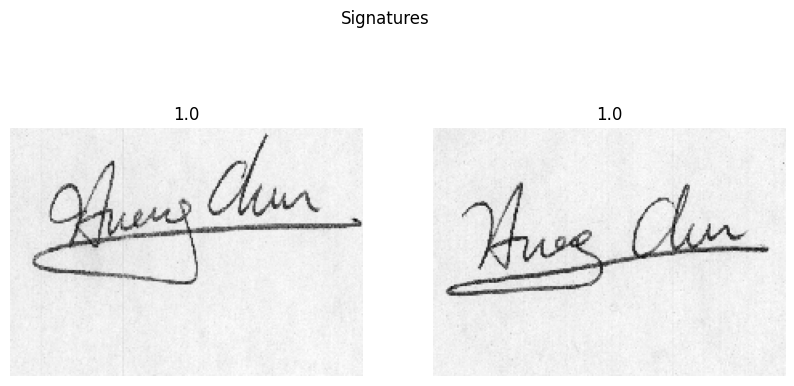

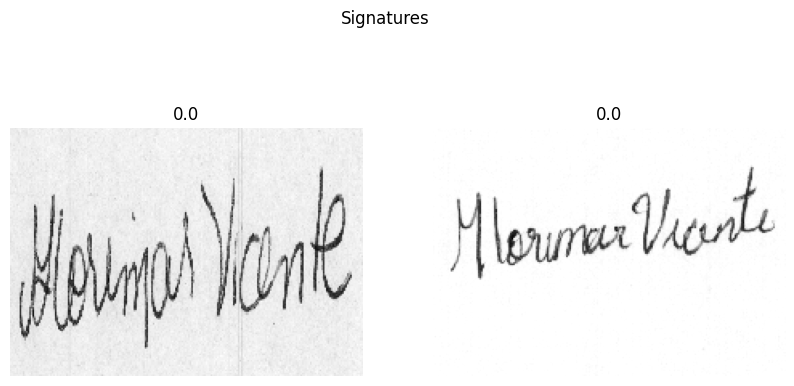

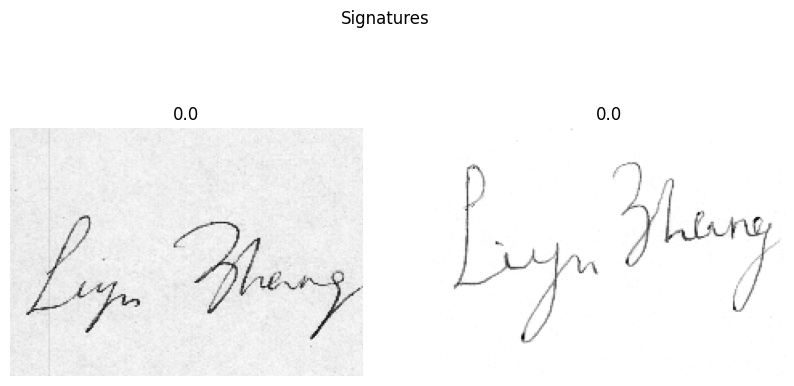

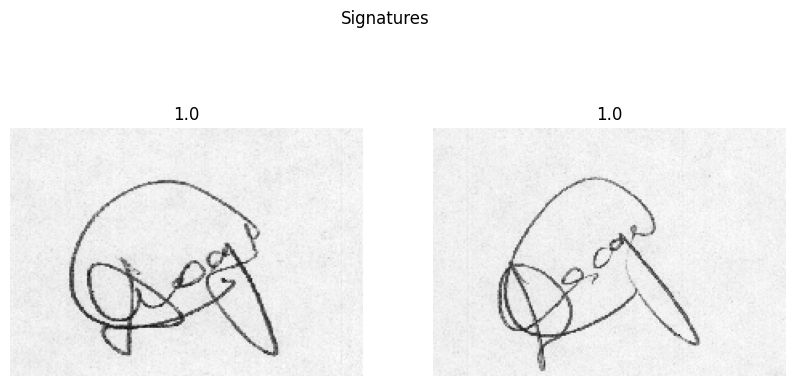

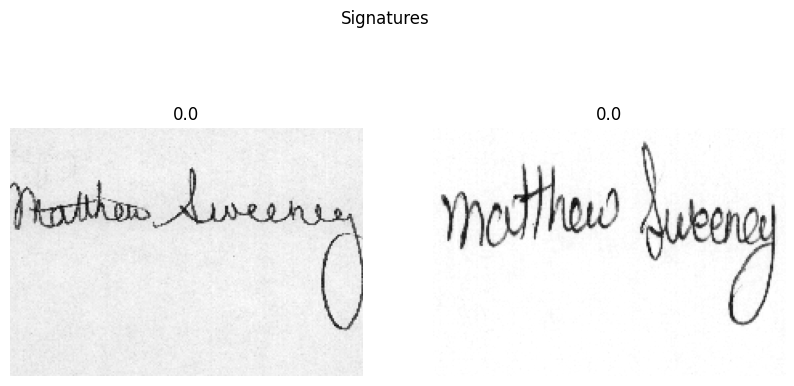

In [18]:
for i in range(1, 100, 20):
  plot_images(images[0], images[1], labels, i, "Signatures")

In [19]:
del val_datagen

## Model

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [21]:
# def get_base_net():
#     input = Input(shape=(155, 220, 1))

#     conv_1 = Conv2D(filters=96, kernel_size=(11, 11))(input)
#     batch_norm_1 = BatchNormalization()(conv_1)
#     activation_1 = Activation('relu')(batch_norm_1)
#     max_pool_1 = MaxPooling2D(pool_size=(3, 3))(activation_1)

#     conv_2 = Conv2D(filters=256, kernel_size=(5, 5))(max_pool_1)
#     batch_norm_2 = BatchNormalization()(conv_2)
#     activation_2 = Activation('relu')(batch_norm_2)
#     max_pool_2 = MaxPooling2D(pool_size=(3, 3))(activation_1)  # Change activation_1 to activation_2

#     dropout_1 = Dropout(rate=0.3)(max_pool_2)

#     conv_3_a = Conv2D(filters=384, kernel_size=(3, 3))(dropout_1)
#     activation_3_a = Activation('relu')(conv_3_a)
#     conv_3_b = Conv2D(filters=256, kernel_size=(3, 3))(activation_3_a)
#     activation_3_b = Activation('relu')(conv_3_b)
#     max_pool_3 = MaxPooling2D(pool_size=(3, 3))(activation_3_b)

#     dropout_2 = Dropout(rate=0.3)(max_pool_3)

#     flat_1 = Flatten()(dropout_2)
#     fc_1 = Dense(units=1024, activation='relu')(flat_1)
#     dropout_3 = Dropout(rate=0.5)(fc_1)
#     fc_2 = Dense(units=128, activation='relu')(dropout_3)
#     return Model(input, fc_2)

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

def get_base_net(input_shape):
    '''Base Siamese Network'''

    in_image = Input(input_shape)

    c1 = Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4,
                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(in_image)
    n1 = tf.nn.local_response_normalization(c1, depth_radius=5, bias=1, alpha=0.0001, beta=0.75)
    p1 = MaxPooling2D((3, 3), strides=(2, 2))(n1)
    zp1 = tf.keras.layers.ZeroPadding2D((2, 2))(p1)

    c2 = Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1,
                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(zp1)
    n2 = tf.nn.local_response_normalization(c2, depth_radius=5, bias=1, alpha=0.0001, beta=0.75)
    p2 = MaxPooling2D((3, 3), strides=(2, 2))(n2)
    d1 = Dropout(0.3)(p2)
    zp2 = tf.keras.layers.ZeroPadding2D((1, 1))(d1)

    c3 = Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1,
                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(zp2)
    zp3 = tf.keras.layers.ZeroPadding2D((1, 1))(c3)

    c4 = Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1,
                kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005))(zp3)
    p3 = MaxPooling2D((3, 3), strides=(2, 2))(c4)
    d2 = Dropout(0.3)(p3)
    f1 = Flatten(name='flatten')(d2)
    fc1 = Dense(1024, kernel_regularizer=regularizers.l2(0.0005), activation='relu',
                kernel_initializer='glorot_uniform')(f1)
    d3 = Dropout(0.5)(fc1)

    out_embs = Dense(128, kernel_regularizer=regularizers.l2(0.0005), activation='relu',
                     kernel_initializer='glorot_uniform')(d3)

    model = tf.keras.models.Model(inputs=in_image, outputs=out_embs)

    return model

In [23]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [24]:
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1.0 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, y_true.dtype)), tf.float32))

In [25]:
input_a = Input(shape=(155, 220, 1))
input_b = Input(shape=(155, 220, 1))

base_net = get_base_net((155, 220, 1))
processed_a = base_net(input_a)
processed_b = base_net(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  6460864   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

In [26]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])

In [29]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-8, verbose=1, initial_lr=1e-4),
    ModelCheckpoint('/content/ckpts/signet.h5', verbose=1, save_weights_only=True, save_best_only=True)
]

In [30]:
BATCH_SIZE = 32
TRAIN_STEPS_PER_EPOCH = train_df.shape[0] // BATCH_SIZE
VAL_STEPS_PER_EPOCH = val_df.shape[0] // BATCH_SIZE
TEST_STEPS = test_df.shape[0] // BATCH_SIZE

In [31]:
train_gen = siamese_data_generator(train_df, batch_size=BATCH_SIZE)
valid_gen = siamese_data_generator(val_df, batch_size=BATCH_SIZE, train=False)
test_gen = siamese_data_generator(test_df, batch_size=BATCH_SIZE, train=False)

In [33]:
if len(os.listdir("/content/ckpts/")) > 0:
  model.load_weights("/content/ckpts/signet.h5")

In [34]:
# hist = model.fit(train_gen, validation_data=valid_gen, epochs=40,
#                 steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
#                 validation_steps=VAL_STEPS_PER_EPOCH,
#                 use_multiprocessing=True,
#                 workers=6, callbacks = callbacks)

## TEST THE MODEL

In [35]:
test_df = pd.read_csv("/content/CSVS/test.csv")
test_gen = siamese_data_generator(test_df, batch_size=BATCH_SIZE, train=False)
TEST_STEPS_PER_EPOCH = test_df.shape[0] // BATCH_SIZE

In [36]:
results = model.evaluate(test_gen, steps=TEST_STEPS_PER_EPOCH)
del test_gen

Not for training
Found 4555 validated image filenames.
Found 4555 validated image filenames.
142/142 [==============================] - 37s 207ms/step - loss: 0.0549 - accuracy: 0.9945


## PLOTS

In [40]:
test_gen = siamese_data_generator(test_df, batch_size=1024, train=False)

In [42]:
one_batch = next(test_gen)
images, true_labels = one_batch

preds = model.predict([images])

Not for training
Found 4555 validated image filenames.
Found 4555 validated image filenames.
32/32 [==============================] - 1s 32ms/step


In [43]:
pred_labels = []
for val in preds:
  if val[0] < 0.3:
    pred_labels.append(1)
  else:
    pred_labels.append(0)

In [49]:
y_true = true_labels
y_pred = pred_labels

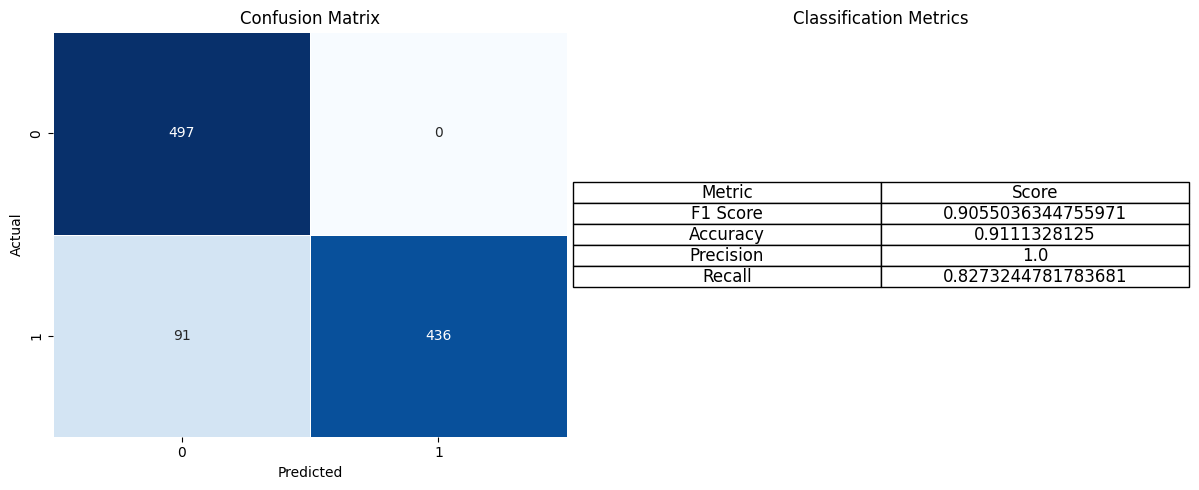

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score

# Calculate classification metrics
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a table for the metrics
metrics_data = [
    ["F1 Score", f1],
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, ax=ax1)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")
ax1.set_title("Confusion Matrix")

# Create a table for the metrics
table = ax2.table(cellText=metrics_data, colLabels=["Metric", "Score"], cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax2.axis("off")
ax2.set_title("Classification Metrics")

plt.tight_layout()
plt.show()


In [48]:
# Print the classification report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       497
         1.0       1.00      0.83      0.91       527

    accuracy                           0.91      1024
   macro avg       0.92      0.91      0.91      1024
weighted avg       0.92      0.91      0.91      1024

